In [1]:
from sklearn.linear_model import LogisticRegression, SGDClassifier, RidgeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.svm import SVC,LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, BaggingClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler
import os
import pickle
import pandas as pd

pd.options.display.max_rows = 35 
pd.options.display.max_columns = None

## Modeling with the Entire Dataset 

- Because the features in the dataset are so different, we first approached our problem with a stacked classifier.  Our goal was that using various different models could capture relationships better and lead to better results 
- **Models we started with**: 
    1. Logistic Regression 
    2. KNearest Neighbors 
    3. Decision Tree 
    4. Gaussian Classifier 
    5. Linear Discriminant Analysis 
    6. LinearSVC 
    7. SDGSVC
    8. ADA 
    9. Bagging 
    10. Ridge 
    11. Random Forest 
    12. Stacked (everything above combined)


- To evaluate the performance for each, we performed a stratified k-fold on the entire data set.  This allowed us to capture 5 scores for each model to determine the best

In [3]:
def get_pickles_norm(): 
    x_train = pickle.load(open(f'../data/processed/pickles/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../data/processed/pickles/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../data/processed/pickles/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../data/processed/pickles/y_test.p', 'rb'))
    X = pickle.load(open('../data/processed/pickles/X.p', 'rb'))
    y = pickle.load(open('../data/processed/pickles/y.p', 'rb'))

    return (x_train, x_test, y_train, y_test), (X,y)

(x_train, x_test, y_train, y_test), (X,y) = get_pickles_norm()


print(f'Original X: {X.shape}\tOriginal y: {y.shape}')
print(f'Train X: {x_train.shape}\tTrain y: {y_train.shape}')
print(f'Test X: {x_test.shape}\tTest y: {y_test.shape}')

y_train = y_train.target.values.ravel()
y_test = y_test.target.values.ravel()
y = y.target.values.ravel()

standard = StandardScaler() 
x_train[['amount_tsh', 'gps_height', 'population', 'time_passed']] = standard.fit_transform(
    x_train[['amount_tsh', 'gps_height', 'population', 'time_passed']])

x_test[['amount_tsh', 'gps_height', 'population', 'time_passed']] = standard.fit_transform(
    x_test[['amount_tsh', 'gps_height', 'population', 'time_passed']])

X[['amount_tsh', 'gps_height', 'population', 'time_passed']] = standard.fit_transform(
    X[['amount_tsh', 'gps_height', 'population', 'time_passed']])

Original X: (57247, 53)	Original y: (57247, 1)
Train X: (38090, 53)	Train y: (38090, 1)
Test X: (8588, 53)	Test y: (8588, 1)


- We used standard scaler to standardize our data for the columns: 
    1. `amount_tsh`
    2. `gps_height`
    3. `population`
    4. `time_passed`

In [61]:
models = {'Log': LogisticRegression(), 'KNN': KNeighborsClassifier(),
          'DT': DecisionTreeClassifier(), 'Gaussian': GaussianNB(), 'LDA': LinearDiscriminantAnalysis(),
           'LinearSVC': LinearSVC(max_iter = 1250), 'SDGSVC': SGDClassifier(),  
          'ADA': AdaBoostClassifier(), 'Bagging': BaggingClassifier(), 'Ridge': RidgeClassifier(), 
          'RF': RandomForestClassifier()}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5)
    scores = cross_val_score(m, X, y, scoring = 'accuracy', cv = cv, n_jobs = 2, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)

Evaluating STACKED: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [1:19:27<00:00, 397.28s/it]


In [62]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('../models/VanillaResults.p', 'wb'))

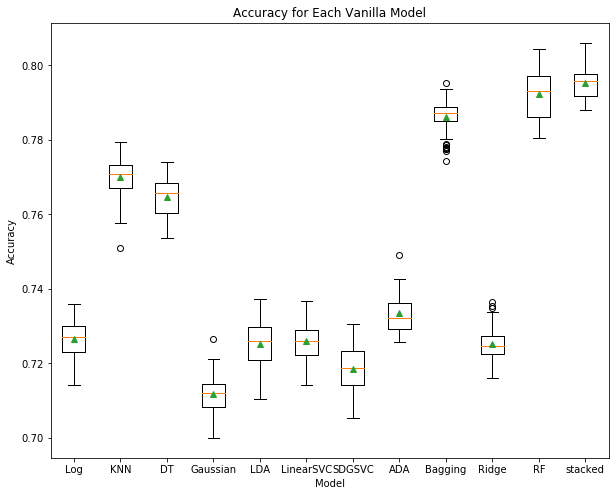

In [63]:
plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy.png')
plt.show()

- As shown above, there was a lot of variation between the accuracy of each model.  Seeing that Logistic, KNN, Gaussian, LDA, LinearSVC, SDGSVC, ADA, and Ridge all performed worse than 75%, we tried the same but excluded thse models to see if there would be any improvement in the stacked classifier
- The best performing classifier was Random Forest, followed by Bagging and Decision Tree. 

In [65]:
models = {'DT': DecisionTreeClassifier(),  'Bagging': BaggingClassifier(), 'RF': RandomForestClassifier()}

#create stacked model
stack_m = [] 
for model, m in models.items(): 
    stack_m.append((model, m))
stack_model = StackingClassifier(estimators = stack_m, final_estimator = LogisticRegression(), cv = 5)
models['stacked'] = stack_model

#test each model and stacking
results = []
model_names = []
pbar = tqdm(models.items())
for model, m in pbar: 
    pbar.set_description(f'Evaluating {model.upper()}')
    cv = RepeatedStratifiedKFold(n_splits = 10, n_repeats = 5)
    scores = cross_val_score(m, X, y, scoring = 'accuracy', cv = cv, n_jobs = 2, 
                             error_score = 'raise')
    results.append(scores)
    model_names.append(model)

Evaluating STACKED: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [29:35<00:00, 443.81s/it]


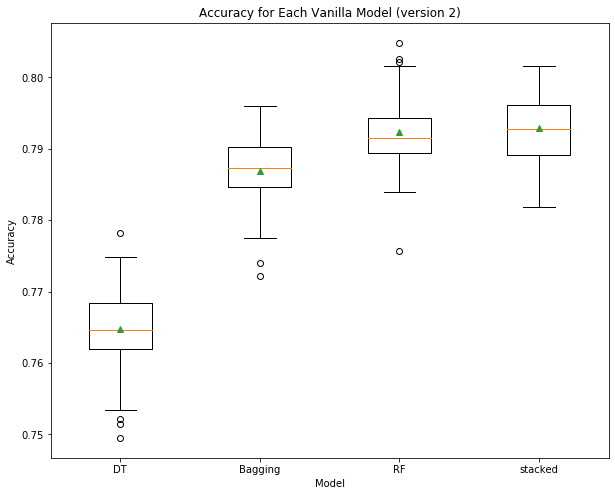

In [66]:
vanilla_dict = {i:y for i,y in zip(model_names, results)}
pickle.dump(vanilla_dict, open('../models/VanillaResults2.p', 'wb'))

plt.figure(figsize = (10,8))
plt.boxplot(results, labels = model_names, showmeans = True)
plt.title('Accuracy for Each Vanilla Model (version 2)')
plt.ylabel('Accuracy'); plt.xlabel('Model')
plt.savefig('figures/BaselineAccuracy.png')
plt.show()

- After using just Decision Tree, Bagging, and Random Forest, our stacked classifier's accuracy improved significantly.  
- However, we can see here that the the Random Forest still performed the best out of the 4
- Because the Random Forest performed the best, we tested the True Positive, False Positive, False Positive, and False Negative rates of the random forest classifier

VANILLA TRAIN
Correct Predictions: 92.99%

VANILLA TEST
Correct Predictions: 73.98%


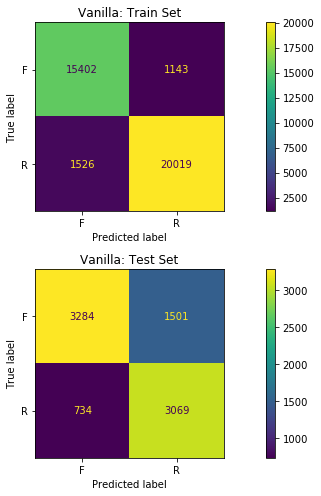

In [42]:
rf = RandomForestClassifier(n_jobs = -1, random_state = 10)
rf.fit(x_train, y_train)

train_pred = rf.predict(x_train)
test_pred = rf.predict(x_test)

train_conf = confusion_matrix(y_train, train_pred)
test_conf = confusion_matrix(y_test, test_pred)

fig, ax = plt.subplots(2, figsize = (12, 7))

plot_confusion_matrix(rf, x_train, y_train, display_labels = ['F', 'R'], ax = ax[0], values_format = '.5g')
plot_confusion_matrix(rf, x_test, y_test, display_labels = ['F', 'R'], ax = ax[1])

ax[0].set_title('Vanilla: Train Set')
ax[1].set_title('Vanilla: Test Set')
plt.tight_layout()

train_true = (sum([train_conf[0][0] + train_conf[1][1]])/len(y_train)) * 100
test_true = (sum([test_conf[0][0] + test_conf[1][1]])/len(y_test)) * 100


print(f'VANILLA TRAIN\nCorrect Predictions: {round(train_true, 2)}%\n')
print(f'VANILLA TEST\nCorrect Predictions: {round(test_true, 2)}%')

- Looking at the accuracy scores for each, we can see that the model over fit onto our training data 
- To fix the overfitting and increase our test accuracy, we then performed RandomCVSearch to determine tuning parameters to better fit our model on data it did not train on 

In [48]:
rf = RandomForestClassifier()
param_grid = {
     'criterion': ['gini', 'entropy'],
    'max_depth': [100, 250, 300, 350, 450],
    'min_samples_split': [5, 8,10, 15],
    'min_samples_leaf': [3, 5, 10, 15],
    'max_features': ['sqrt', 'log2'],
}

cv = RepeatedStratifiedKFold(n_splits = 7, n_repeats =5)
gs = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = cv, n_jobs = -1, verbose = 1, n_iter = 50)

gs.fit(x_train, y_train)

print('Best Estimators')
print(gs.best_estimator_)

Fitting 35 folds for each of 50 candidates, totalling 1750 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   14.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.3min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  8.2min
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed: 11.6min finished


Best Estimators
RandomForestClassifier(max_depth=250, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5)


TUNED TRAIN
Correct Predictions: 85.63%

TUNED TEST
Correct Predictions: 75.55%


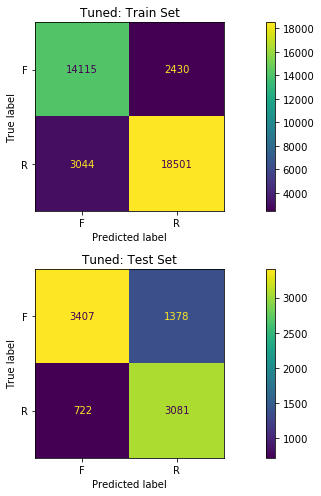

In [50]:
tuned_model = gs.best_estimator_

train_pred = tuned_model.predict(x_train)
test_pred = tuned_model.predict(x_test)

fig, ax = plt.subplots(2, figsize = (12, 7))

plot_confusion_matrix(tuned_model, x_train, y_train, display_labels = ['F', 'R'], ax = ax[0], values_format = '.5g')
plot_confusion_matrix(tuned_model, x_test, y_test, display_labels = ['F', 'R'], ax = ax[1])

ax[0].set_title('Tuned: Train Set')
ax[1].set_title('Tuned: Test Set')
plt.tight_layout()

train_conf = confusion_matrix(y_train, train_pred)
test_conf = confusion_matrix(y_test, test_pred)

train_true = (sum([train_conf[0][0] + train_conf[1][1]])/len(y_train)) * 100
test_true = (sum([test_conf[0][0] + test_conf[1][1]])/len(y_test)) * 100


print(f'TUNED TRAIN\nCorrect Predictions: {round(train_true, 2)}%\n')
print(f'TUNED TEST\nCorrect Predictions: {round(test_true, 2)}%')

- As seen above, the tuned classifier did 

In [5]:
orig_dict = {'Lake Nyasa' : 'nya', 'Lake Victoria' : 'vic', 'Pangani' : 'pang', 'Ruvuma / Southern Coast' : 'ruv', \
                 'Internal' : 'int', 'Lake Tanganyika' : 'tang', 'Wami / Ruvu' : 'wami', 'Rufiji' : 'ruf',
             'Lake Rukwa' : 'rukwa'}


new_dict = {y:i for i,y in orig_dict.items()}
scores = []
basins = []
basin_model_dict= {} 
pbar = tqdm(os.listdir('../data/processed/pickles/basins/'))
for i in pbar:
    if i in ['.DS_Store', '.ipynb_checkpoints']: 
        continue 
    basins.append(i)
    pbar.set_description(f'Testing and Tuning RF Classifier for: {new_dict[i].upper()}')
    x_train = pickle.load(open(f'../data/processed/pickles/basins/{i}/x_train.p', 'rb'))
    x_test = pickle.load(open(f'../data/processed/pickles/basins/{i}/x_test.p', 'rb'))
    y_train = pickle.load(open(f'../data/processed/pickles/basins/{i}/y_train.p', 'rb'))
    y_test = pickle.load(open(f'../data/processed/pickles/basins/{i}/y_test.p', 'rb'))
    
    x_train.drop('basin', axis =1, inplace = True)
    x_test.drop('basin', axis =1, inplace = True)
    y_train = y_train.values.ravel()
    y_test = y_test.values.ravel()
    
    rf = RandomForestClassifier()
   
    param_grid = {
     'criterion': ['gini', 'entropy'],
    'max_depth': [100, 250, 300, 350, 450],
    'min_samples_split': [5, 8,10, 15],
    'min_samples_leaf': [3, 5, 10, 15],
    'max_features': ['sqrt', 'log2'],
}
    standard = StandardScaler()
    x_train[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']] = standard.fit_transform(
                                 x_train[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']]
    )
    x_test[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']] = standard.fit_transform(
        x_test[['amount_tsh', 'gps_height', 'population', 'time_passed', 'longitude', 'latitude']]
    )
    cv = RepeatedStratifiedKFold(n_splits = 7, n_repeats = 5)
    gs = RandomizedSearchCV(estimator = rf, param_distributions = param_grid, cv = cv, n_jobs = 13, 
                            n_iter = 75)

    gs.fit(x_train, y_train)
    pickle.dump(gs, open(f'../models/basins/{i}_GridSearch.p', 'wb'))
    basin_dict = dict(model = gs, x_train = x_train, y_train = y_train, x_test = x_test, y_test = y_test) 
    basin_model_dict[i] = basin_dict
    

pickle.dump(basin_model_dict, open(f'../models/TunedBasinModels.p', 'wb'))


for idx, i in enumerate(basin_model_dict.keys()): 
    print(i)
    basin_dict = basin_model_dict[i]
    model = basin_dict['model']
    print(model.best_estimator_)

Testing and Tuning RF Classifier for: WAMI / RUVU: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [18:23<00:00, 110.39s/it]

int
RandomForestClassifier(criterion='entropy', max_depth=250, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5)
nya
RandomForestClassifier(criterion='entropy', max_depth=100, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5)
pang
RandomForestClassifier(criterion='entropy', max_depth=300, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5)
ruf
RandomForestClassifier(criterion='entropy', max_depth=100, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=8)
rukwa
RandomForestClassifier(max_depth=300, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5)
ruv
RandomForestClassifier(max_depth=100, max_features='sqrt', min_samples_leaf=3,
                       min_samples_split=5)
tang
RandomForestClassifier(criterion='entropy', max_depth=450, max_features='sqrt',
                       min_samples_leaf=3, min_samples_split=5)
vi

Internal
TUNED TRAIN
Correct Predictions: 63.94%

TUNED TEST
Correct Predictions: 79.55%

Lake nyasa
TUNED TRAIN
Correct Predictions: 65.98%

TUNED TEST
Correct Predictions: 89.69%

Pangani
TUNED TRAIN
Correct Predictions: 65.59%

TUNED TEST
Correct Predictions: 73.44%

Rufiji
TUNED TRAIN
Correct Predictions: 69.44%

TUNED TEST
Correct Predictions: 79.45%

Lake rukwa
TUNED TRAIN
Correct Predictions: 59.24%

TUNED TEST
Correct Predictions: 72.8%

Ruvuma / southern coast
TUNED TRAIN
Correct Predictions: 66.92%

TUNED TEST
Correct Predictions: 80.45%

Lake tanganyika
TUNED TRAIN
Correct Predictions: 59.41%

TUNED TEST
Correct Predictions: 76.97%

Lake victoria
TUNED TRAIN
Correct Predictions: 60.41%

TUNED TEST
Correct Predictions: 75.78%

Wami / ruvu
TUNED TRAIN
Correct Predictions: 94.16%

TUNED TEST
Correct Predictions: 80.69%



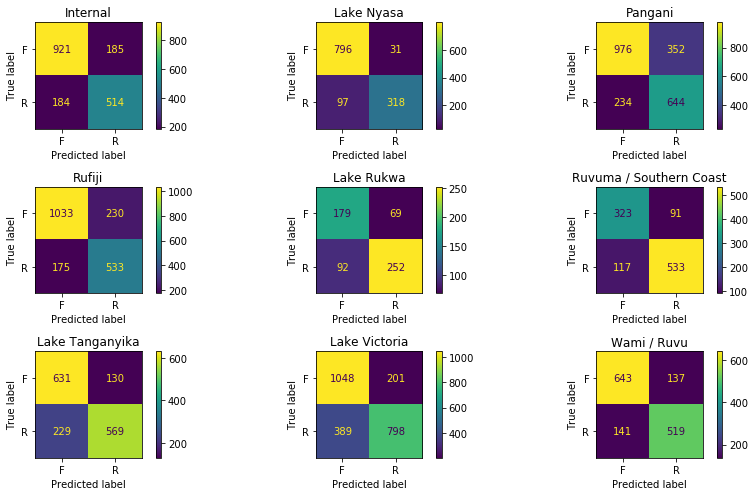

In [6]:
orig_dict = {'Lake Nyasa' : 'nya', 'Lake Victoria' : 'vic', 'Pangani' : 'pang', 'Ruvuma / Southern Coast' : 'ruv', \
                 'Internal' : 'int', 'Lake Tanganyika' : 'tang', 'Wami / Ruvu' : 'wami', 'Rufiji' : 'ruf',
             'Lake Rukwa' : 'rukwa'}


new_dict = {y:i for i,y in orig_dict.items()}
basin_model_dict = pickle.load(open(f'../models/TunedBasinModels.p', 'rb'))


fig, ax = plt.subplots(3, 3, figsize = (12,7))
cm_dict = {}
for idx, i in enumerate(basin_model_dict.keys()): 
    basin_dict = basin_model_dict[i]
    model =basin_dict['model'].best_estimator_
    x_test = basin_dict['x_test']
    y_test = basin_dict['y_test']
    plot_confusion_matrix(model, x_test, y_test, 
                          display_labels = ['F', 'R'], ax = ax[idx//3, idx%3])
    ax[idx//3, idx%3].set_title(f'{new_dict[i]}')
    cm_dict[i] = confusion_matrix(y_test, model.predict(x_test))
    
    
    train_pred = model.predict(x_train)
    test_pred = model.predict(x_test)
    train_conf = confusion_matrix(y_train, train_pred)
    test_conf = confusion_matrix(y_test, test_pred)

    train_true = (sum([train_conf[0][0] + train_conf[1][1]])/len(y_train)) * 100
    test_true = (sum([test_conf[0][0] + test_conf[1][1]])/len(y_test)) * 100

    print(f'{new_dict[i].capitalize()}')
    print(f'TUNED TRAIN\nCorrect Predictions: {round(train_true, 2)}%\n')
    print(f'TUNED TEST\nCorrect Predictions: {round(test_true, 2)}%\n')
    
plt.tight_layout()
plt.savefig(f'figures/BASINS_confusion_matrix.png')
pickle.dump(cm_dict, open(f'../models/Basins/BasinCMDict.p', 'wb'))